<a href="https://colab.research.google.com/github/mayankgrwl97/deep-unsupervised-learning-berkeley/blob/master/demos/lecture2/01_fitting_simple_1d_discrete_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Negative Log Likelihood References:**
1.   [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy)
2.   [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
3.   [torch.nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
4.   [torch.nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax)
5.   [Understanding - torch.nn.NLLLoss](https://discuss.pytorch.org/t/understanding-nllloss-function/23702/6)
6.   [Cross Entropy for Classification](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451)
7.   [YouTube - A Short Introduction to Entropy, Cross-Entropy, KL-Divergence (10 mins.)](https://www.youtube.com/watch?v=ErfnhcEV1O8)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

**Visualization Utilities**

In [2]:
def plot_hist(data, bins=10, xlabel='x', ylabel='Probability', title='', density=None):
    bins = np.concatenate((np.arange(bins) - 0.5, [bins - 1 + 0.5]))

    plt.figure()
    plt.hist(data, bins=bins, density=True)

    if density:
        plt.plot(density[0], density[1], label='distribution')
        plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_train_curves(epochs, train_losses, test_losses, title=''):
    x = np.linspace(0, epochs, len(train_losses))
    plt.figure()
    plt.plot(x, train_losses, label='train_loss')
    if test_losses:
        plt.plot(x, test_losses, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

**Data Utilites**

In [3]:
class NumpyDataset(data.Dataset):
    def __init__(self, array, transform=None):
        super().__init__()
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        x = self.array[index]
        if self.transform:
            x = self.transform(x)
        return x

def generate_1d_data(n, d):
    """
    Params:
        n -- sample size
        d -- dimensions
    Algorithm:
        a -- NormDist(mu=0.3, sigma=0.1)
        b -- NormDist(mu=0.8, sigma=0.05)
        samples -- 'n' samples uniformly chosen from distributions 'a' and 'b'
        np.linspace(0.0, 1.0, d) -- create d bins in range [0.0, 1.0]
        np.digitize(samples, bins) -- for each sample 'x' returns
                                      indices i which satisfy:
                                      bins[i-1] <= x < bins[i]

    """
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(n)
    b = 0.8 + 0.05 * rand.randn(n)
    mask = rand.rand(n) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, d)).astype('float32') # Output in range - [1, d]

**Initializing Hyperparameters and Visualizing Dataset**

Sample Data: [48. 34. 40. 80. 49. 81. 40. 29. 29. 34.] 

Min: 1.0, Max:95.0 

Probability of sampling 80: 0.059 



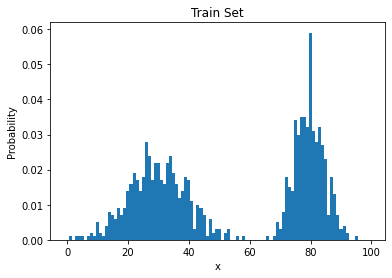

In [4]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, d = 1000, 100 # Try increasing n_train, the curve becomes smoother (closer to true distribution)

train_data = generate_1d_data(n_train, d)
print(f'Sample Data: {train_data[:10]} \n')
print(f'Min: {min(train_data)}, Max:{max(train_data)} \n')
print(f'Probability of sampling 80: {(train_data == 80).sum() / len(train_data)} \n')

plot_hist(train_data, bins=d, title='Train Set')
train_dset = NumpyDataset(train_data)
train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True)

**Training Code** <br>
We optimize the model using gradient descent and minimize negative log-likelihood

In [5]:
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        loss = model.nll(x) # Compute loss, nll -> negative log likelihood (Objective - Minimize nll)
        optimizer.zero_grad() # Reset Grads
        loss.backward() # Perform Backward Pass
        optimizer.step() # Update weights using gradient descent


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            loss = model.nll(x) # nll -> negative log likelihood (Objective - Minimize nll)
            total_loss += loss * x.shape[0] # Scale loss according to batch size
        avg_loss = total_loss / len(data_loader.dataset) # Average loss across dataset
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()

        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss(model, test_loader)
            test_losses.append(test_loss)

        if epoch in [0, 2, 10, 50, 99]:
            plot_hist(train_loader.dataset.array, bins=d,
                      title=f'Epoch {epoch}', density=model.get_density())
    if test_loader is not None:
      print('Test Loss', test_loss)

    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

**Model 1: Simple Histogram**

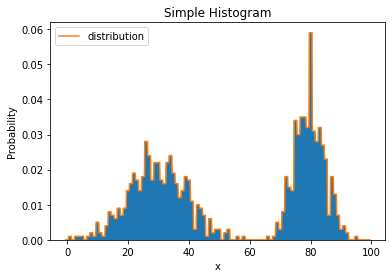

In [6]:
class SimpleHistogram(nn.Module):
    """Simple Count based Histogram as explained in Lecture 2"""
    def __init__(self, d, data):
        super().__init__()
        self.d = d
        self.probs = torch.zeros(d)
        for i in range(d):
            self.probs[i] = (data == [i]).sum() / len(data) # probability for a bin #i
        return

    def get_density(self):
        x = np.linspace(-0.5, self.d - 0.5, 1000)
        with torch.no_grad():
            y = self.probs.unsqueeze(1).repeat(1, 1000 // self.d).view(-1).numpy()
        return x, y

simple_hist = SimpleHistogram(d, train_data)

# Exact overelap with target distribution
plot_hist(train_loader.dataset.array, bins=d,
          title='Simple Histogram', density=simple_hist.get_density())

**Model 1-v2: Histogram**

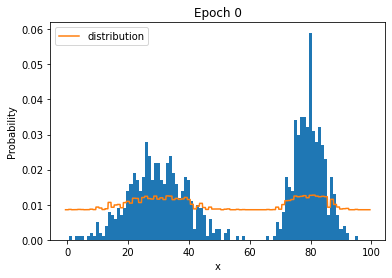

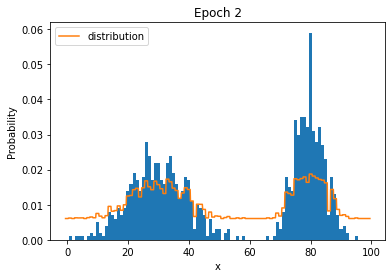

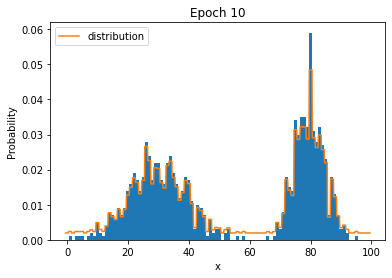

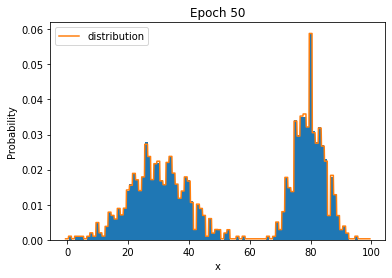

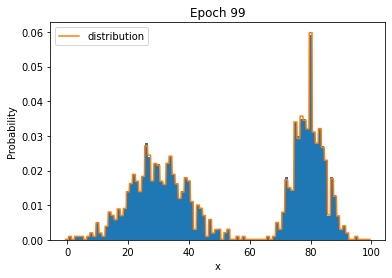

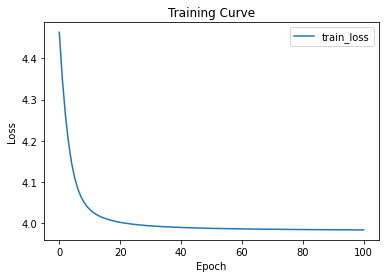

In [7]:
class Histogram(nn.Module):
    """Histogram trained using negative log likelihood loss function"""
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

    # Compute loss as negative log-likelihood
    def nll(self, x):
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
        return F.cross_entropy(logits, x.long())

    def get_density(self):
        x = np.linspace(-0.5, self.d - 0.5, 1000)
        with torch.no_grad():
            y = F.softmax(self.logits, dim=0).unsqueeze(1).repeat(1, 1000 // self.d).view(-1).numpy()
        return x, y

hist = Histogram(d)
train_epochs(hist, train_loader, None, dict(epochs=100, lr=2.5e-2))

**Model 2: Discretized Mixture of Logistics**<br/>
Reference: [Logistic Distribution](https://en.wikipedia.org/wiki/Logistic_distribution)

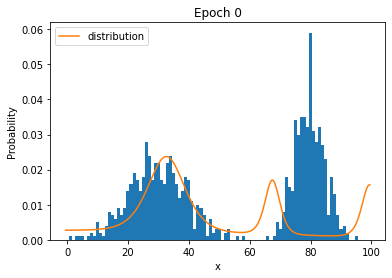

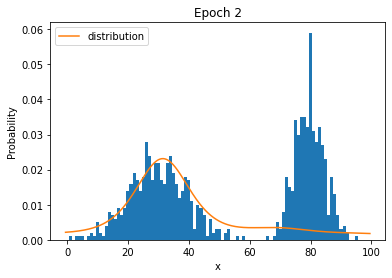

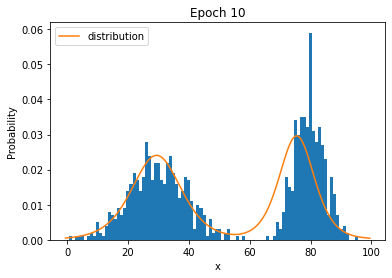

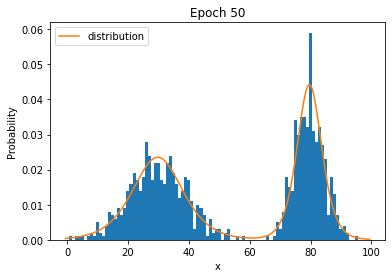

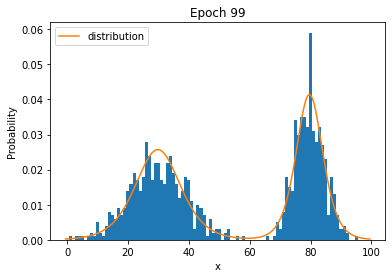

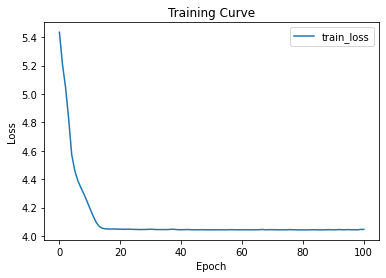

In [8]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, n_mix=4):
        super().__init__()
        self.d = d
        self.n_mix = n_mix

        self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
        self.means = nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d, requires_grad=True) # Initialize means at equal intervals
        self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True) # Spread parameter initialized randomly

    def nll(self, x):
        x = x.unsqueeze(1).repeat(1, self.n_mix) # b x n_mix
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # 1 x n_mix
        inv_scales = torch.exp(-log_scales)

        plus_in = inv_scales * (x + 0.5 - means)
        min_in = inv_scales * (x - 0.5 - means)

        cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
        cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

        cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
        log_cdf_plus = torch.sigmoid(inv_scales * (0.5 - means))
        log_cdf_min = torch.sigmoid(inv_scales * (d - 1.5 - means))

        x_log_probs = torch.where(x < 0.001, log_cdf_plus,
                                  torch.where(x > d - 1 - 1e-3,
                                              log_cdf_min, log_cdf_delta))
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return -torch.mean(torch.logsumexp(log_probs, dim=1))

    def get_density(self):
        x = np.linspace(-0.5, self.d - 1 + 0.5, 1000)

        with torch.no_grad():
            x_pt = torch.FloatTensor(x).unsqueeze(1)
            means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
            pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)

            # Calculate pdf of logistic distributions and weight them
            # according to learned mixture probabilities
            x_in = (x_pt - means) * torch.exp(-log_scales)
            log_pdf = x_in - log_scales - 2 * F.softplus(x_in)
            log_pdf = log_pdf + pi_log_probs
            log_pdf = torch.logsumexp(log_pdf, dim=1)
            pdf = log_pdf.exp()

        return x, pdf.numpy()

discretized = MixtureOfLogistics(d, n_mix=4)
train_epochs(discretized, train_loader, None, dict(epochs=100, lr=1e-1))

**Comparing with Test Data (with missing data)**

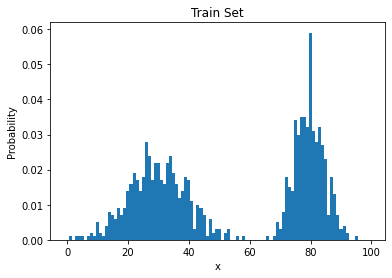

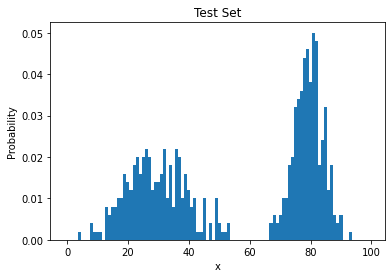

In [9]:
n_train, n_test, d = 1000, 500, 100

train_data = generate_1d_data(n_train, d)
plot_hist(train_data, bins=d, title='Train Set')
train_dset = NumpyDataset(train_data)
train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True)

test_data = generate_1d_data(n_test, d)
plot_hist(test_data, bins=d, title='Test Set')
test_dset = NumpyDataset(test_data)
test_loader = data.DataLoader(test_dset, batch_size=128, shuffle=True)

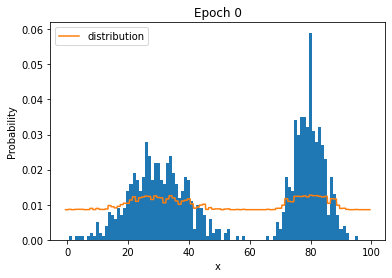

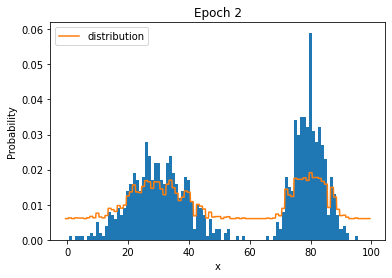

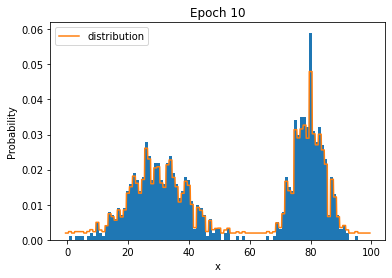

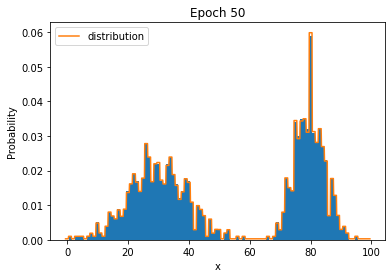

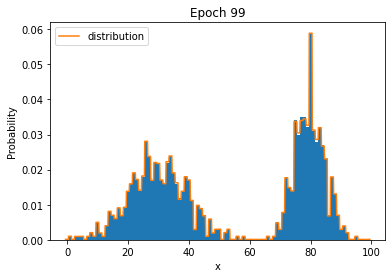

Test Loss 4.0598554611206055


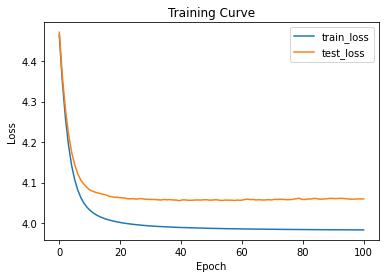

In [10]:
hist = Histogram(d)
train_epochs(hist, train_loader, test_loader, dict(epochs=100, lr=2.5e-2))

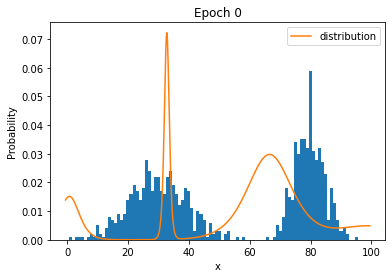

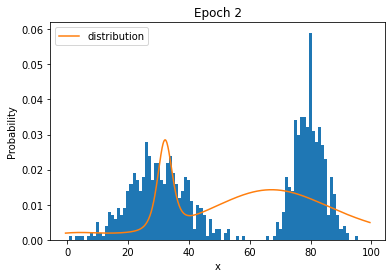

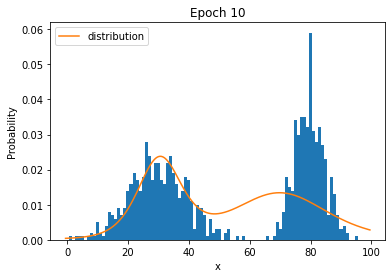

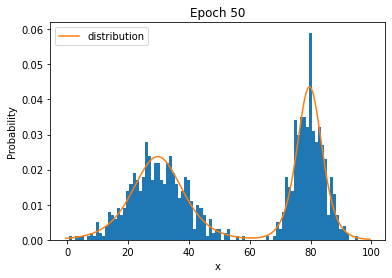

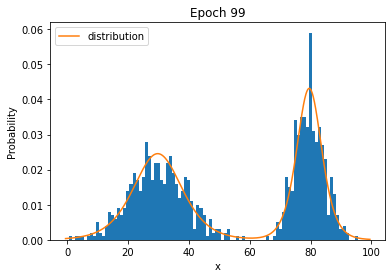

Test Loss 4.0314812660217285


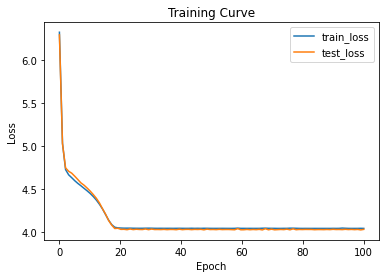

In [11]:
discretized = MixtureOfLogistics(d, n_mix=4)
train_epochs(discretized, train_loader, test_loader, dict(epochs=100, lr=1e-1))